### EDA on Crime Reports for City of Austin<a id='eda'>

## Contents<a id='Contents'></a>
* [EDA](#eda)
  * [Contents](#Contents)
    * [Imports](#imports)
    * [Load The Crime reports Data](#load_data)
        * [How is the dataset? Does it have Time Series components?](#hows_the_dataset)
    * [Choosing years 2013 to 2022 for EDA](#choose_years)
    * [Visualizing Number of Crime(NOC) Distributions](#viz_nocs)
      * [EDA on Council Districts](#council_districts)
          * [Aggregations on council_district using .agg()](#council_district_agg)
          * [Council District #9 on map](#council_9_map)
      * [EDA on APD sectors](#apd_sectors)
          * [APD sectors in Austin](#apd_sectors_map)
          * [Aggregations on APD Sectors](#apd_sector_agg)
      * [EDA on Census_tract](#census_tract)
      * [EDA on zip_code](#zip_codes)
      * [Crime Count Visualization(yearly,monthly,daily, hourly)](#daily_crime)
      * [EDA on Clearance Status](#clearance_status)
      * [Group Aggregation for top ten crimes](#top_10_gp_agg)
    * [Time series Dataset Prep using pivot_table method](#pivot_table)
        * [Missing Values](#missing_values)
        * [Filling the missing values](#fillna_method)
        * [Pairwise relationships between these ten crimes](#pairplots)
        * [lag plots](#lag_plots)
    * [Summary of EDA](#summary)
     

#### Library Imports<a id='imports'>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import requests
import time
import missingno as msno
import pyarrow as pa
import pyarrow.parquet as pq
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

#### Load Data<a id='load_data'>

In [2]:
df_eda = pd.read_parquet('crime_reports_wrangled.parquet')

In [3]:
df_eda.head()

,incident_report_number,crime_type,ucr_code,family_violence,location_type,address,clearance_date,clearance_status,zip_code,council_district,...,district,pra,census_tract,x_coordinate,y_coordinate,latitude,longitude,location,occurred_date_time,reported_date_time
0,20121171927,RECKLESS DAMAGE,1401,N,RESIDENCE / HOME,3154 HWY 71 E,None,None,None,None,...,None,None,None,None,None,None,None,None,2012-04-26 22:34:00,2012-04-26 23:04:00
1,20072871892,FAMILY DISTURBANCE,3400,N,RESIDENCE / HOME,9715 N FM 620 RD,None,None,None,None,...,None,None,None,None,None,None,None,None,2007-10-14 20:01:00,2007-10-14 20:01:00
2,2006471156,FAMILY DISTURBANCE,3400,N,RESIDENCE / HOME,7000 DECKER 1422,None,None,None,None,...,None,None,None,None,None,None,None,None,2006-02-16 14:25:00,2006-02-16 14:25:00
3,20045017276,IDENTITY THEFT,4022,N,None,11441 I35 EF N,2004-09-01T00:00:00.000,None,None,None,...,None,None,None,None,None,None,None,None,2003-07-31 12:00:00,2004-04-14 09:45:00
4,20173300229,FAMILY DISTURBANCE,3400,N,RESIDENCE / HOME,13204 LIPTON LP,None,None,None,None,...,None,None,None,None,None,None,None,None,2017-11-26 07:43:00,2017-11-26 07:43:00


### How is the dataset? Does it have Time Series components?<a id='hows_the_dataset'>

Columns that i observed for these four categories: <br>
(a) Time : 'clearance_date', 'occurred_date_time', 'reported_date_time', 'month',
       'year', 'hour'

(b) Location: 'location_type', 'address', 'zip_code', 'council_district', 'sector',
       'district', 'pra', 'census_tract', 'x_coordinate', 'y_coordinate',
       'latitude', 'longitude'

(c) Features: ??

(d) Target : crime_type,clearance_status, family_violence

In [4]:
df_eda.shape

(2000000, 21)

In [5]:
df_eda.columns

Index(['incident_report_number', 'crime_type', 'ucr_code', 'family_violence',
       'location_type', 'address', 'clearance_date', 'clearance_status',
       'zip_code', 'council_district', 'sector', 'district', 'pra',
       'census_tract', 'x_coordinate', 'y_coordinate', 'latitude', 'longitude',
       'location', 'occurred_date_time', 'reported_date_time'],
      dtype='object')

<AxesSubplot:>

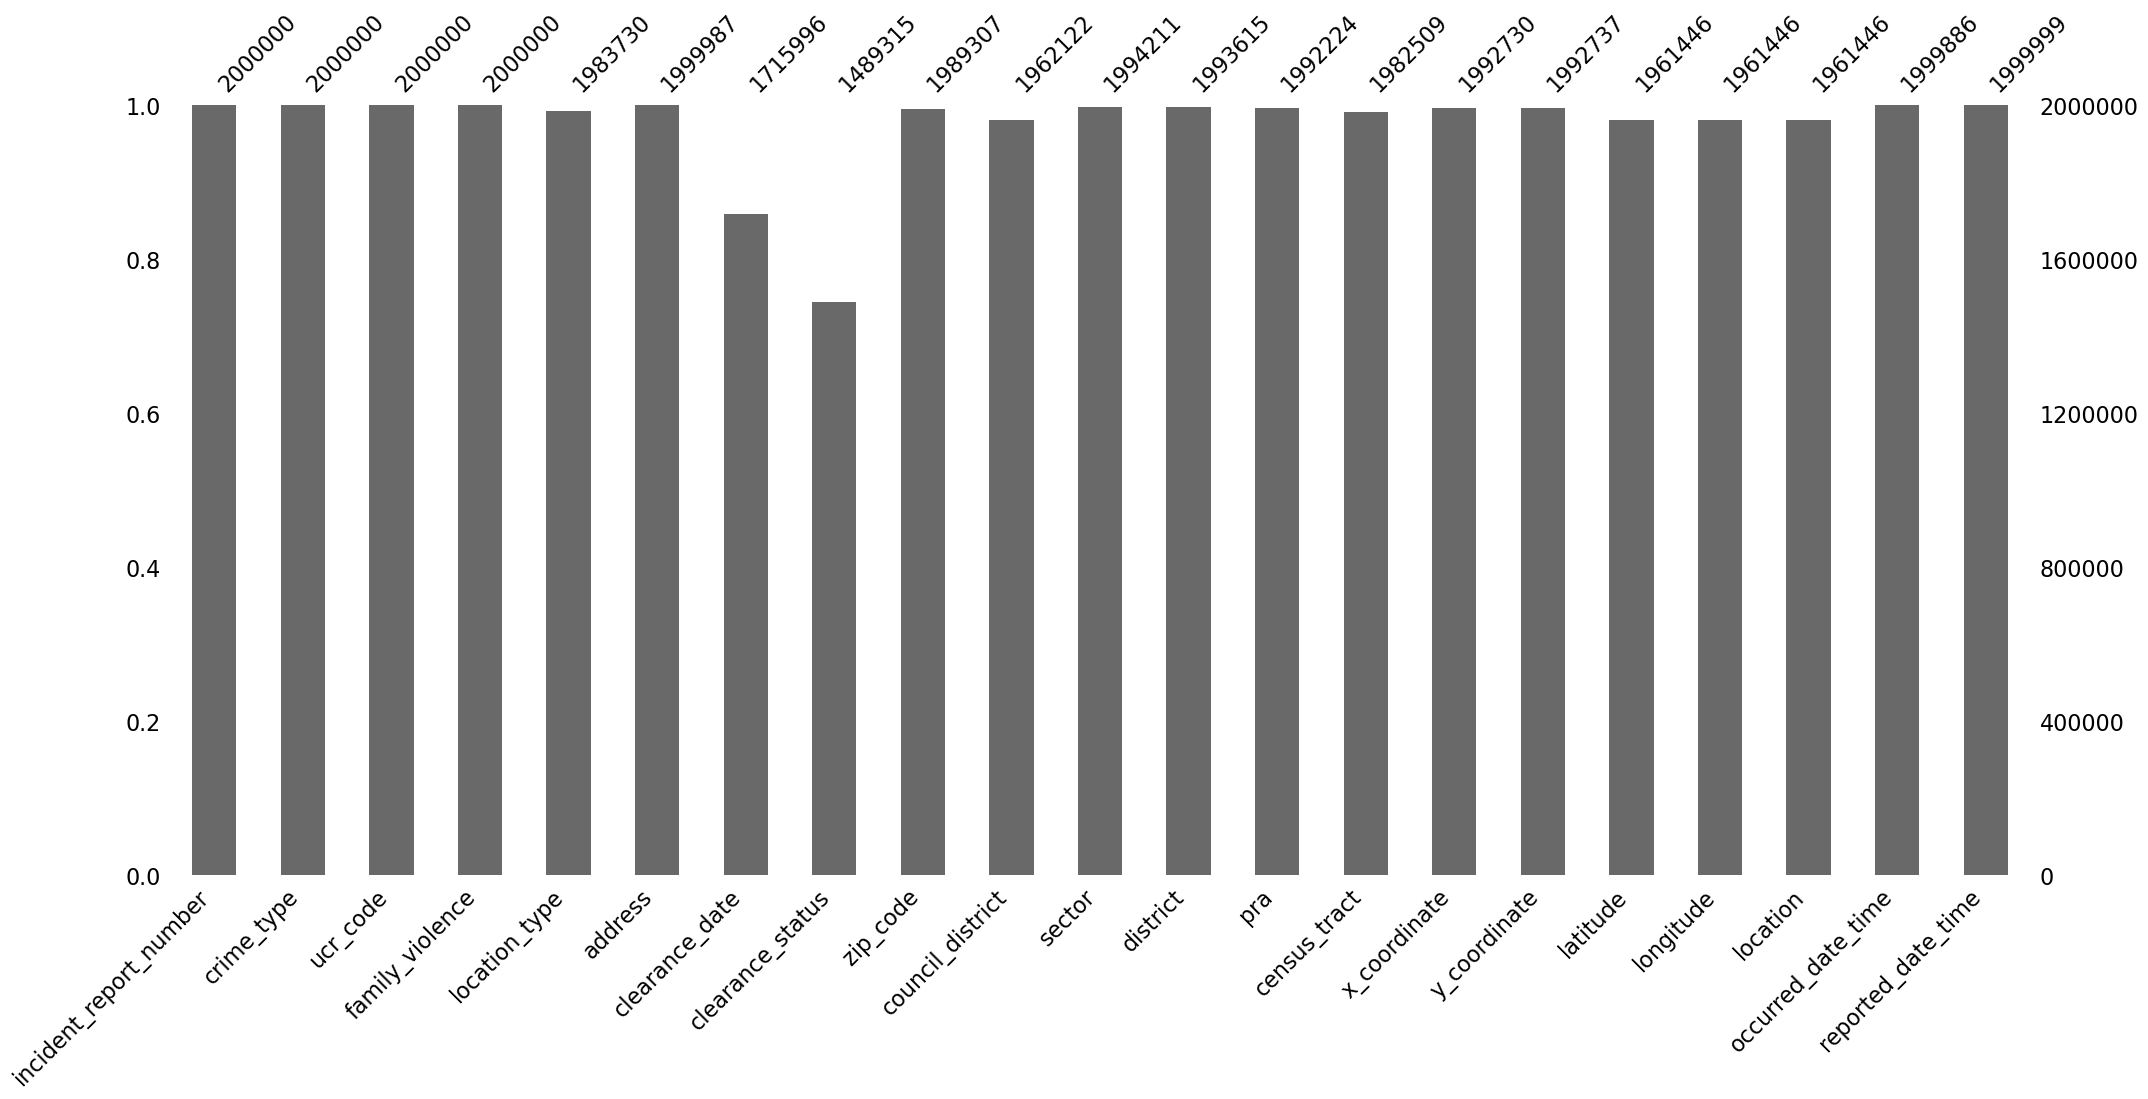

In [6]:
msno.bar(df_eda)

In [7]:
df_eda['ucr_code'].value_counts().count()

390

In [8]:
df_eda['crime_type'].value_counts().count()

429

In [9]:
df_eda['sector'].unique()

array([None, 'BA', 'FR', 'ID', 'DA', 'AD', 'CH', 'HE', 'GE', 'ED', '88',
       'F6', '95', 'F', 'D', 'H', 'UT', '4', 'ADAM', 'I', 'A', 'SC',
       'BAKR', 'WM', 'G', 'AP', '1124', 'CHAR', 'AS', 'C', 'C1', '8', '6',
       '8805', '2', '83', 'E', 'F7', '44', 'D6', 'D8', 'HR', 'GR', '.',
       'RD', '1', 'GRGE', 'B', 'A1', '99', 'FRNK', 'E1', 'E4', 'A2',
       'HENRY', 'DAVID', 'DAVD', 'HENR', 'ADA<', 'AV', 'IDA', 'CE', 'FRK',
       'EDWD', '21'], dtype=object)

In [10]:
df_eda['sector'].mask(df_eda['sector'].isin(['BA','B','BAKR']) ,'BAKER', inplace=True)


In [11]:
df_eda['sector'].mask(df_eda['sector'].isin(['FR','F','FRNK','FRK']) ,'FRANK', inplace=True)

In [12]:
df_eda['sector'].mask(df_eda['sector'].isin(['AD','ADAM','A','ADA<']) ,'ADAM', inplace=True)

In [13]:
df_eda['sector'].mask(df_eda['sector'].isin(['CH','CHAR','CE','C']) ,'CHARLIE', inplace=True)

In [14]:
df_eda['sector'].mask(df_eda['sector'].isin(['DA','DAVID','D','DAVD']) ,'DAVID', inplace=True)

In [15]:
df_eda['sector'].mask(df_eda['sector'].isin(['HE','HR','HENRY','HENR']) ,'HENRY', inplace=True)

In [16]:
df_eda['sector'].mask(df_eda['sector'].isin(['ED','E','EDWD']) ,'EDWARD', inplace=True)

In [17]:
df_eda['sector'].mask(df_eda['sector'].isin(['GE','G','GR','GRGE']) ,'GEORGE', inplace=True)

In [19]:
df_eda['sector'].mask(df_eda['sector'].isin(['ID','I','IDA']) ,'IDA', inplace=True)

In [20]:
df_eda['sector'].mask(df_eda['sector'].isin(['AP']) ,'APT', inplace=True)

In [21]:
df_eda['sector'].unique()

array([None, 'BAKER', 'FRANK', 'IDA', 'DAVID', 'ADAM', 'CHARLIE', 'HENRY',
       'GEORGE', 'EDWARD', '88', 'F6', '95', 'H', 'UT', '4', 'SC', 'WM',
       'APT', '1124', 'AS', 'C1', '8', '6', '8805', '2', '83', 'F7', '44',
       'D6', 'D8', '.', 'RD', '1', 'A1', '99', 'E1', 'E4', 'A2', 'AV',
       '21'], dtype=object)

In [22]:
df_eda_sectors = df_eda[df_eda['sector'].isin(['BAKER', 'FRANK', 'IDA', 'DAVID', 'ADAM', 'CHARLIE', 'HENRY',
       'GEORGE', 'EDWARD', 'APT'])]

In [23]:
df_eda_sectors.head()

,incident_report_number,crime_type,ucr_code,family_violence,location_type,address,clearance_date,clearance_status,zip_code,council_district,...,district,pra,census_tract,x_coordinate,y_coordinate,latitude,longitude,location,occurred_date_time,reported_date_time
8,2013851154,SEXUAL ASSAULT OF CHILD/OBJECT,1707,Y,RESIDENCE / HOME,900 BLOCK E 32ND ST,2013-04-11T00:00:00.000,C,78705,9,...,1,348,4,0,0,None,None,None,2009-01-01 00:01:00,2013-03-26 16:56:00
9,20161800084,RAPE OF A CHILD,204,Y,RESIDENCE / HOME,6900 BLOCK BRANCHWOOD DR,2016-07-01T00:00:00.000,C,78744,2,...,8,530,24.41,0,0,None,None,None,2016-06-28 01:05:00,2016-06-28 01:05:00
10,2010701921,RAPE,200,Y,RESIDENCE / HOME,400 BLOCK ANGEL OAK ST,2010-03-18T00:00:00.000,C,78748,5,...,2,542,24.38,0,0,None,None,None,2010-03-04 19:15:00,2010-03-11 17:06:00
11,20071820003,RAPE,200,N,RESIDENCE / HOME,1700 BLOCK WOOTEN DR,2007-08-02T00:00:00.000,O,78757,7,...,7,247,405,0,0,None,None,None,2007-07-01 12:00:00,2007-07-01 12:00:00
12,20062192048,SEXUAL ASSAULT W/ OBJECT,1700,N,RESIDENCE / HOME,500 BLOCK E OLTORF ST,2006-08-22T00:00:00.000,None,78704,9,...,2,479,23.23,0,0,None,None,None,2006-08-07 22:28:00,2006-08-07 22:28:00


<AxesSubplot:>

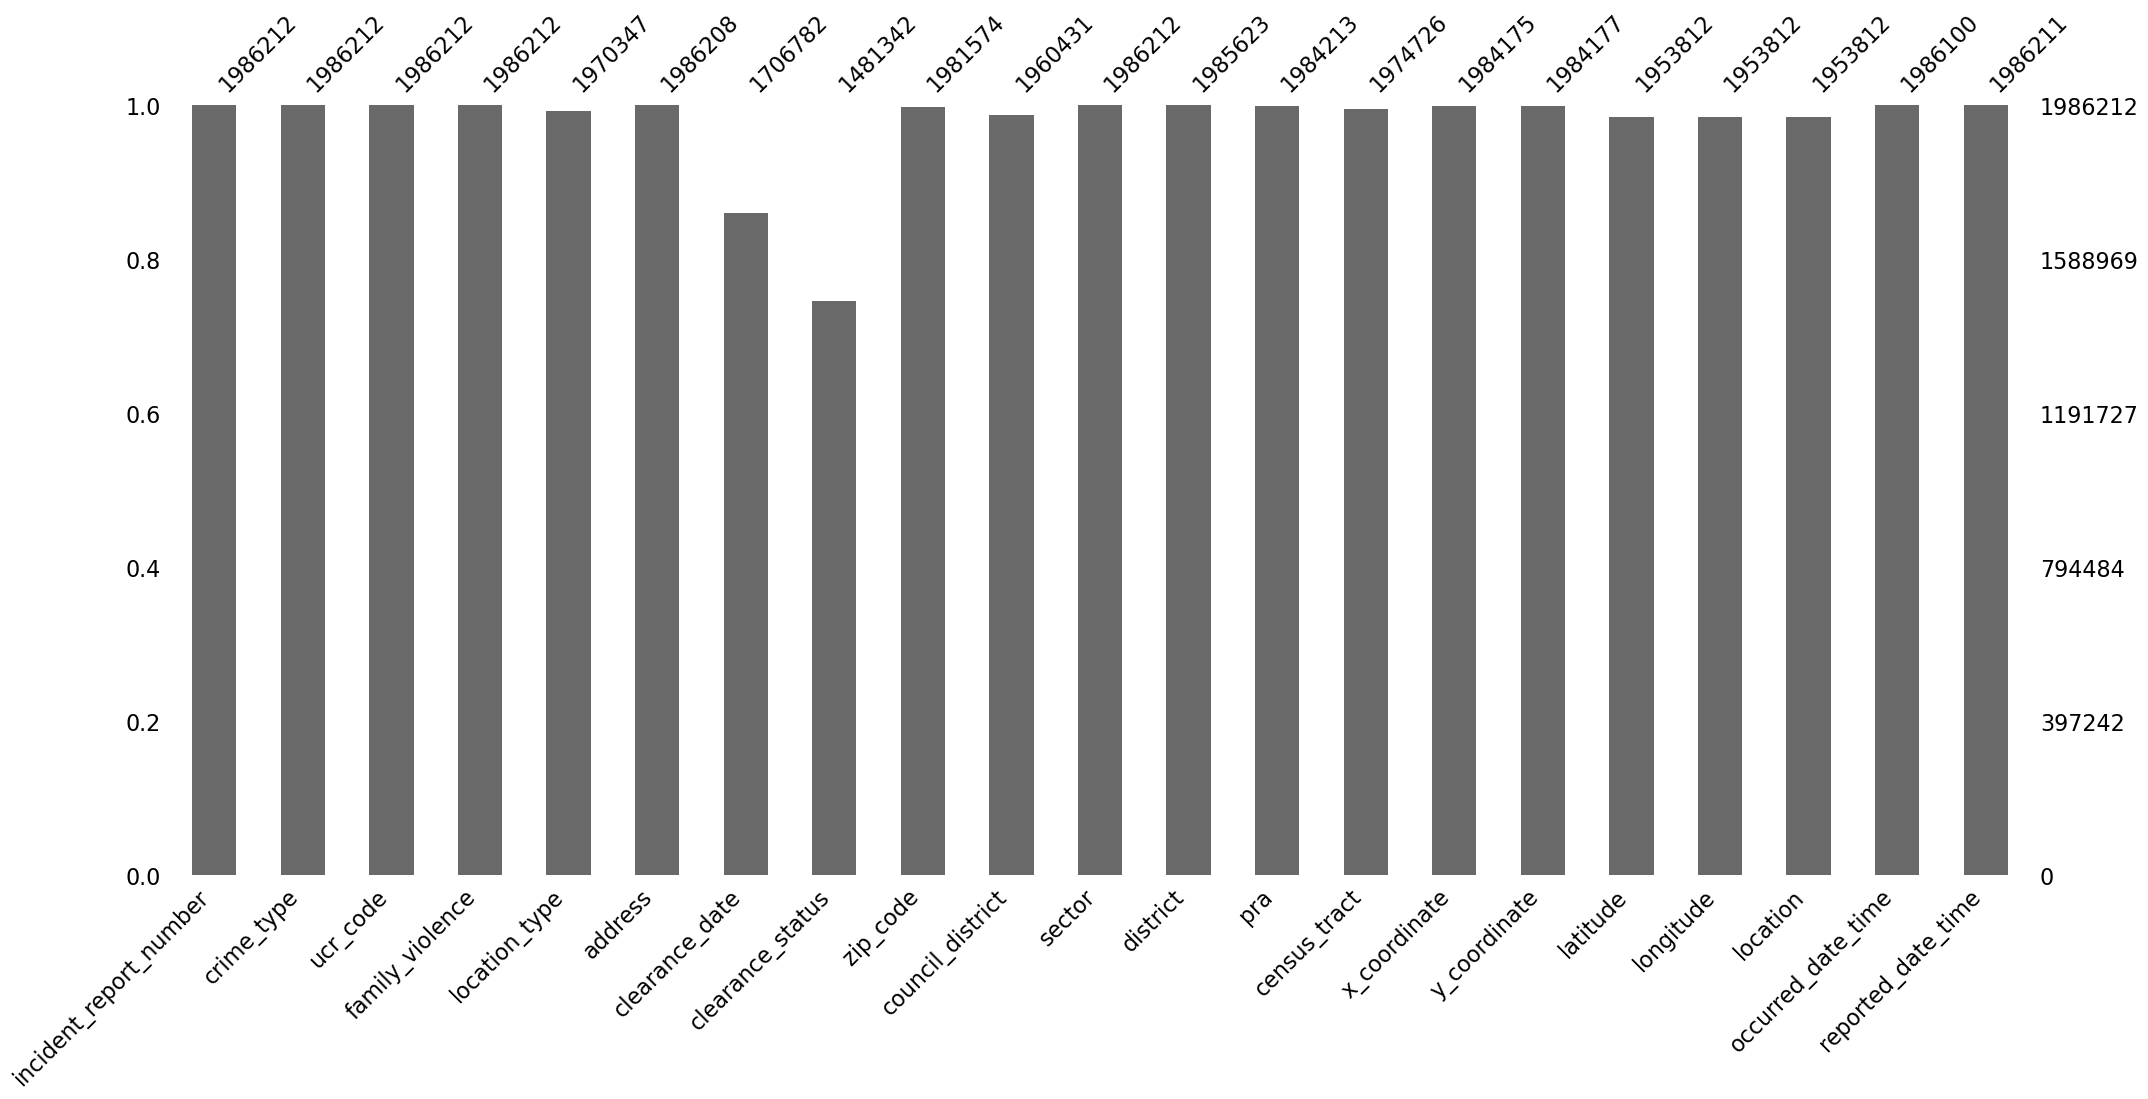

In [24]:
msno.bar(df_eda_sectors)

In [25]:
df_eda_sectors['ucr_code'].unique()

array(['1707', '204', '200', '1700', '3829', '902', '2703', '2006',
       '1706', '1709', '500', '900', '1799', '202', '208', '610', '1712',
       '502', '3722', '1710', '600', '2011', '206', '1000', '609', '2716',
       '3104', '1722', '4199', '2610', '2732', '2609', '1716', '1801',
       '1505', '2700', '2704', '608', '3400', '3401', '1400', '2002',
       '4022', '1199', '3442', '1701', '1825', '2733', '1106', '2400',
       '2013', '2100', '402', '2014', '1803', '1718', '2707', '2728',
       '1702', '1600', '2800', '3414', '2010', '909', '2611', '1705',
       '3299', '303', '2005', '1504', '305', '2008', '2805', '1800',
       '3212', '1715', '4003', '1724', '300', '2605', '3009', '2411',
       '1708', '410', '2710', '901', '302', '405', '3458', '205', '910',
       '3399', '700', '201', '2905', '408', '903', '1720', '2712', '100',
       '2902', '1109', '1503', '1601', '2012', '3010', '3203', '4200',
       '601', '3724', '619', '1810', '1818', '2408', '607', '2802',
      

In [26]:
cols=['ucr_code','crime_type','family_violence','address','zip_code','sector','occurred_date_time']

In [27]:
df_eda_sectors_clean = df_eda_sectors[cols]

In [28]:
df_eda_sectors_clean.shape

(1986212, 7)

In [29]:
df_eda_sectors_clean.head()

,ucr_code,crime_type,family_violence,address,zip_code,sector,occurred_date_time
8,1707,SEXUAL ASSAULT OF CHILD/OBJECT,Y,900 BLOCK E 32ND ST,78705,BAKER,2009-01-01 00:01:00
9,204,RAPE OF A CHILD,Y,6900 BLOCK BRANCHWOOD DR,78744,FRANK,2016-06-28 01:05:00
10,200,RAPE,Y,400 BLOCK ANGEL OAK ST,78748,FRANK,2010-03-04 19:15:00
11,200,RAPE,N,1700 BLOCK WOOTEN DR,78757,IDA,2007-07-01 12:00:00
12,1700,SEXUAL ASSAULT W/ OBJECT,N,500 BLOCK E OLTORF ST,78704,DAVID,2006-08-07 22:28:00


In [137]:
df_eda_sectors_clean['ucr_code'].value_counts().head(50)

601     213053
600     187767
3400    166902
1400    115807
900     115428
500      68768
2100     60767
2703     57185
3401     55358
700      45013
607      44147
902      41898
3722     41328
3442     36176
2716     35756
502      33047
1803     31411
1818     29529
1800     29217
4022     22664
402      22115
901      20105
609      19444
3299     19202
2704     17658
1199     16139
1106     12604
1000     12575
608      12132
3458     12117
2400     11941
1108     11767
2721      9981
300       9501
603       8845
1402      8594
2102      8391
3211      8154
3829      7875
2001      7622
2707      7607
614       7487
303       7039
610       6890
3399      6452
3604      5944
3296      5881
3817      5843
410       5828
1005      5514
Name: ucr_code, dtype: int64

In [138]:
common_crimes = df_eda_sectors_clean['ucr_code'].value_counts().nlargest(50).index

In [139]:
common_crimes

Index(['601', '600', '3400', '1400', '900', '500', '2100', '2703', '3401',
       '700', '607', '902', '3722', '3442', '2716', '502', '1803', '1818',
       '1800', '4022', '402', '901', '609', '3299', '2704', '1199', '1106',
       '1000', '608', '3458', '2400', '1108', '2721', '300', '603', '1402',
       '2102', '3211', '3829', '2001', '2707', '614', '303', '610', '3399',
       '3604', '3296', '3817', '410', '1005'],
      dtype='object')

In [140]:
df_sec_common_crimes = df_eda_sectors_clean[df_eda_sectors_clean['ucr_code'].isin(common_crimes)] 

In [141]:
df_sec_common_crimes.head()

,ucr_code,crime_type,family_violence,address,zip_code,sector,occurred_date_time
14,3829,PROTECTIVE ORDER,N,UNKNOWN,None,ADAM,2018-12-04 14:53:00
20,902,ASSAULT CONTACT-SEXUAL NATURE,N,200 BLOCK COMAL ST,78702,CHARLIE,2017-06-13 16:56:00
21,2703,HARASSMENT,N,11100 BLOCK JOLLYVILLE RD,78759,ADAM,2016-07-01 20:53:00
38,3829,PROTECTIVE ORDER,N,UNKNOWN,None,FRANK,2015-10-04 10:52:00
39,3829,PROTECTIVE ORDER,N,UNKNOWN,None,DAVID,2018-10-17 15:24:00


In [142]:
df_sec_common_crimes.shape

(1752468, 7)

In [143]:
df_sec_common_crimes.dtypes

ucr_code                      object
crime_type                    object
family_violence               object
address                       object
zip_code                      object
sector                        object
occurred_date_time    datetime64[ns]
dtype: object

In [144]:
df_sec_common_crimes['occurred_date'] = pd.to_datetime(df_sec_common_crimes['occurred_date_time'], format='%Y-%m-%d').dt.floor('D')

In [146]:
df_sec_common_crimes.head()

,ucr_code,crime_type,family_violence,address,zip_code,sector,occurred_date_time,occurred_date
14,3829,PROTECTIVE ORDER,N,UNKNOWN,None,ADAM,2018-12-04 14:53:00,2018-12-04
20,902,ASSAULT CONTACT-SEXUAL NATURE,N,200 BLOCK COMAL ST,78702,CHARLIE,2017-06-13 16:56:00,2017-06-13
21,2703,HARASSMENT,N,11100 BLOCK JOLLYVILLE RD,78759,ADAM,2016-07-01 20:53:00,2016-07-01
38,3829,PROTECTIVE ORDER,N,UNKNOWN,None,FRANK,2015-10-04 10:52:00,2015-10-04
39,3829,PROTECTIVE ORDER,N,UNKNOWN,None,DAVID,2018-10-17 15:24:00,2018-10-17


In [147]:
df_sec_common_crimes.shape

(1752468, 8)

In [148]:
df_crimes_by_sector=df_sec_common_crimes.groupby(['occurred_date','sector','ucr_code']).agg(
    count=('crime_type', 'count')
       
 ).reset_index()



In [149]:
df_crimes_by_sector.shape

(962009, 4)

In [150]:
df_crimes_by_sector.head()

,occurred_date,sector,ucr_code,count
0,2003-01-01,ADAM,1000,1
1,2003-01-01,ADAM,1199,1
2,2003-01-01,ADAM,1400,2
3,2003-01-01,ADAM,2100,2
4,2003-01-01,ADAM,2703,2


In [ ]:
#  ['601', '600', '3400', '1400', '900', '500', '2100', '2703', '3401', '700']

In [151]:
#saving this file
csv_name = "crimes_summary_gp_apd_code.csv"
df_crimes_by_sector.to_csv(csv_name, index=False)

In [106]:
df_600 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '600']

In [108]:
df_600.crime_type.value_counts()

THEFT                        61044
THEFT-NO SUSPECT/FOLLOWUP      393
Name: crime_type, dtype: int64

In [127]:
df_601 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '601']

In [128]:
df_601.crime_type.value_counts()

BURGLARY OF VEHICLE              57748
BURGLARY OF VEH-NO SUSPECT/FU     3555
Name: crime_type, dtype: int64

In [125]:
df_3400 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '3400']

In [126]:
df_3400.crime_type.value_counts()

FAMILY DISTURBANCE    54750
Name: crime_type, dtype: int64

In [123]:
df_1400 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '1400']

In [124]:
df_1400.crime_type.value_counts()

CRIMINAL MISCHIEF               50842
CRIMINAL MISCHIEF-NO SUSPECT      825
Name: crime_type, dtype: int64

In [121]:
df_900 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '900']

In [122]:
df_900.crime_type.value_counts()

ASSAULT W/INJURY-FAM/DATE VIOL    39859
ASSAULT WITH INJURY               31057
Name: crime_type, dtype: int64

In [119]:
df_500 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '500']

In [120]:
df_500.crime_type.value_counts()

BURGLARY OF RESIDENCE            36319
BURG OF RES - FAM/DATING ASLT      801
BURG OF RES - SEXUAL NATURE         80
Name: crime_type, dtype: int64

In [117]:
df_2100 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '2100']

In [118]:
df_2100.crime_type.value_counts()

DWI    36345
Name: crime_type, dtype: int64

In [115]:
df_3401 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '3401']

In [116]:
df_3401.crime_type.value_counts()

DISTURBANCE - OTHER    35703
Name: crime_type, dtype: int64

In [113]:
df_700 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '700']

In [114]:
df_700.crime_type.value_counts()

AUTO THEFT    30372
Name: crime_type, dtype: int64

In [111]:
df_2703 = df_crimes_by_sector[df_crimes_by_sector['ucr_code'] == '2703']

In [112]:
df_2703.crime_type.value_counts()

HARASSMENT    35432
Name: crime_type, dtype: int64

In [ ]:
df_eda[df_eda['ucr_code'].isin(['601','600','900'])] #3400-family_disturbance,1400 - criminal_mischief,burglary vehicle-601,theft-600,assault with injurt-900

In [ ]:
df_eda['occurred_date'] = pd.to_datetime(df_eda['occurred_date_time'], format='%Y-%m-%d').dt.floor('D')

In [ ]:
df_eda['year'] = df_eda['occurred_date'].dt.year

In [ ]:
df_eda['month'] = df_eda['occurred_date'].dt.year

In [ ]:
df_eda['day'] = df_eda['occurred_date'].dt.year

In [ ]:
df_eda['hour'] = df_eda['occurred_date'].dt.year

In [ ]:
df_eda.dtypes

In [ ]:
df_eda['year'] = df_eda['year'].astype('Int64')

In [ ]:
df_eda.head(3)

In [ ]:
crimes_per_year = df_eda['year'].value_counts().sort_index()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values,color='b')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set(xlabel='Year', ylabel='# crimes occurred')
plt.title('Number of occurred crimes per year')
plt.show()

### Choosing years 2013 to 2023 for EDA<a id='choose_years'>

In [ ]:
df_13_22 = df_eda[df_eda.year.between(2013, 2024)]

In [ ]:
df_13_22.head()

In [ ]:
df_13_22.shape

In [ ]:
df_13_22.info()

In [ ]:
msno.bar(df_13_22)

### EDA on Council Districts<a id='council_districts'>
    
    Which Council district has highest number of crime incidents in Austin?

In [ ]:
df_13_22.council_district.unique()

In [ ]:
df_13_22.council_district.value_counts()

In [ ]:
df_13_22.council_district.value_counts().info()

### Aggregations on council_district using .agg()<a id='council_district_agg'>

In [ ]:
df_13_22.groupby(["year","council_district"]).agg(
    count=('council_district', 'count')
    
 ).sort_values(by = ['year', 'count'], ascending = [True, False])

In [ ]:

df_13_22['day'] = df_13_22['occurred_date_time'].apply(lambda x: x.strftime('%A')) 

In [ ]:
df_13_22.head(2)

In [ ]:
df_13_22['month'] = df_13_22['occurred_date'].dt.month

In [ ]:
df_13_22['day'] = df_13_22['occurred_date'].dt.day

In [ ]:
df_13_22['hour'] = df_13_22['occurred_date_time'].dt.hour

### Visualizing Number of Crime(NOC) Distributions<a id='viz_nocs'>

In [ ]:
# Specifying the values to plot (year, month, day, hour, district, sector)
noc_year = pd.DataFrame(data = df_13_22["year"].value_counts().reset_index().values,
                        columns = ["year", "noc"]).sort_values("year").reset_index(drop = True)
noc_month = pd.DataFrame(data = df_13_22["month"].value_counts().reset_index().values,
                        columns = ["month", "noc"]).sort_values("month").reset_index(drop = True)
noc_day = pd.DataFrame(data = df_13_22["day"].value_counts().reset_index().values,
                        columns = ["day", "noc"]).sort_values("day").reset_index(drop = True)
noc_hour = pd.DataFrame(data = df_13_22["hour"].value_counts().reset_index().values,
                        columns = ["hour", "noc"]).sort_values("hour").reset_index(drop = True)
noc_district = pd.DataFrame(data = df_13_22["council_district"].value_counts().reset_index().values,
                        columns = ["district", "noc"])
noc_sector = pd.DataFrame(data = df_13_22["sector"].value_counts().reset_index().values,
                        columns = ["sector", "noc"]).sort_values("noc", ascending = False).reset_index(drop = True).head(30)

# Create a subplot with 3 rows and 2 cols
fig = make_subplots(rows = 3, cols = 2,
                   specs = [[{"type" : "scatter"}, {"type" : "scatter"}], [{"type" : "scatter"},
                             {"type" : "scatter"}], [{"type" : "bar"}, {"type" : "bar"}]],
                   subplot_titles = ("NOC per Year", "NOC per Month", "NOC per Day", "NOC per Hour", "NOC per District", "NOC per Sector"))

# Plot the values
fig.add_trace(go.Scatter(x = noc_year["year"],
                        y = noc_year["noc"]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = noc_month["month"],
                        y = noc_month["noc"]), row = 1, col = 2)
fig.add_trace(go.Scatter(x = noc_day["day"],
                        y = noc_day["noc"]), row = 2, col = 1)
fig.add_trace(go.Scatter(x = noc_hour["hour"],
                        y = noc_hour["noc"]), row = 2, col = 2)
fig.add_trace(go.Bar(x = noc_district["district"],
                        y = noc_district["noc"]), row = 3, col = 1)
fig.add_trace(go.Bar(x = noc_sector["sector"],
                        y = noc_month["noc"]), row = 3, col = 2)

# Update x axes parameters
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Month", range=[0, 13], row=1, col=2)
fig.update_xaxes(title_text="Day", row=2, col=1)
fig.update_xaxes(title_text="Hour",row=2, col=2)
fig.update_xaxes(title_text="District", row=3, col=1)
fig.update_xaxes(title_text="Sector", row=3, col=2)

# Update y axes parameters
fig.update_yaxes(title_text="Crime Count", row=1, col=1)
fig.update_yaxes(title_text="Crime Count",row=1, col=2)
fig.update_yaxes(title_text="Crime Count", row=2, col=1)
fig.update_yaxes(title_text="Crime Count", row=2, col=2)
fig.update_yaxes(title_text="Crime Count", row=3, col=1)
fig.update_yaxes(title_text="Crime Count", row=3, col=2)

fig.update_layout(showlegend=False,title_text="Distributions of Total NOC Between 2013-2022", height=900)


### Council District #9 on map<a id='council_9_map'>
    
    I got this image from source: https://www.austinmonitor.com/wp-content/uploads/2014/12/map.jpg

In [ ]:
from IPython.display import Image
Image(filename='austin_council_districts.png') 


### Observations:

1. Crime rate is declining. From 2103 to 2018 it decline but some spike is noted in 2019 but declining since then.  <br/>
2. Big dip in the crime rate in the months of February and November<br/>
3. Crime rate is very low on Sunday and Prakes on Friday<br />
4. Hourly crime rate is high at noon and midnight. Very low around 5 am. <br />
5. For council_district 9, 3, 4 there seems to be high crime rates.
6. APD sector Baker, Henry, George shows high crime reported cases. 


### Visualizing council district 9 on the Austin map

In [ ]:
# import folium package
import folium
from folium import plugins
# Map method of folium return Map object
 
# Here we pass coordinates of Gfg
# and starting Zoom level = 12
my_map1 = folium.Map(location = [30.27536, -97.73221],zoom_start = 12 )
# CircleMarker with radius
folium.CircleMarker(location = [30.27536, -97.73221],
                    radius = 80, popup = ' district_9 ').add_to(my_map1)

my_map1

### Choosing council district 9 to analyze  

In [ ]:
df_13_22_dist9 = df_13_22[df_13_22.council_district == '9']

In [ ]:
df_13_22_dist9.shape

In [ ]:
df_13_22_dist9.head()

In [ ]:
df_13_22_dist9['category_description'].value_counts().head(10)

In [ ]:
df_13_22_dist9['zip_code'].value_counts()

In [ ]:
df_13_22_dist9['sector'].value_counts()

### EDA on APD sectors<a id='apd_sectors'>

### APD sectors in Austin<a id='apd_sectors_map'>
    
    I got this image from the source: https://www.austintexas.gov/edims/document.cfm?id=168703

In [ ]:
Image(filename='apd_sectors.png') 

### Aggregations on APD Sectors<a id='apd_sector_agg'>

In [ ]:
sector_year=df_13_22_dist9.groupby(["year","sector"]).agg(
    count=('crime_type', 'count')
       
 ).reset_index().rename(
    columns={'year':'year','sector' : 'sector','count' : 'noc'})

sector_year.head(10)


In [ ]:
px.bar(sector_year, x = "year", y = "noc", color = "sector", title = "APD Sectors under council district(9)- NOC(2013-2022) ", text = "noc")

In [ ]:
sector_year.head(20)

In [ ]:
fig = px.line(sector_year, x = "year", y = "noc", color = "sector", labels =  {"noc" : "Number of Crime",
                                                                       "year" : "Year",
                                                                       "sector" : "APD Sector"}, title = "Crimes per Year under these APD sectors")

fig.update_layout(
    font_color="#5642C5",
    title_font_color="#5642C5",
    legend_title_font_color="#5642C5",
    font_size = 14
)

In [ ]:

sector_hour = pd.DataFrame(data = (df_13_22_dist9.groupby(["hour","sector"]).count()[['crime_type']]).reset_index().values,
                        columns= ["hour","sector","noc"]).sort_values('hour').reset_index(drop=True)

fig = px.line(sector_hour, x = "hour", y = "noc", color = "sector", labels =  {"noc" : "Number of Crime",
                                                                       "hour" : "Hour",
                                                                       "sector" : "APD Sector"}, title = "Crimes per hour under these APD sectors")

fig.update_layout(
    font_color="#5642C5",
    title_font_color="#5642C5",
    legend_title_font_color="#5642C5",
    font_size = 14
)

### EDA on Census_tract<a id='census_tract'>

Census Tracts are small, relatively permanent statistical subdivisions of a county or statistically equivalent entity that can be updated by local participants prior to each decennial census as part of the Census Bureau's Participant Statistical Areas Program (PSAP)

In [ ]:
df_13_22_dist9.census_tract.value_counts()

#### Choosing censust tract 11 as it has highest number of crimes reported

In [ ]:
df_13_22_dist9[df_13_22_dist9.census_tract == '11']

### Council District 9  ---> Census Tract 11

In [ ]:
df_11_census= df_13_22_dist9[df_13_22_dist9.census_tract == '11']

In [ ]:
df_11_census.shape

In [ ]:
df_11_census.sector.value_counts()

In [ ]:
df_11_census.zip_code.value_counts()

##### To visualize census tract which is under council district 9, I made use ot Tableau and took the screen shot and circled the area to highlight  the area for better depiction

This is my public tableau where I had saved this file: https://public.tableau.com/app/profile/anita.durg

In [ ]:
Image(filename='78701_zip.png') 

### Council District 9 ---> Census Tract 11 ----> Zip_code 78701

In [ ]:
df_78701= df_11_census[df_11_census.zip_code == '78701']

In [ ]:
df_78701.shape

In [ ]:
df_all_78701 = df_13_22[df_13_22.zip_code == '78701']

In [ ]:
df_all_78701.shape

In [ ]:
df_sector_ge_ba = df_13_22[df_13_22.sector.isin(['GE','BA'])]

In [ ]:
df_sector_ge_ba.shape

### EDA on zip_codes <a id='zip_codes'>

### Crime Count Visualization(yearly,monthly,daily, hourly)<a id='daily_crime'>

In [ ]:
crime_cnt_year = pd.DataFrame(data = df_78701["year"].value_counts().reset_index().values,
                        columns = ["year", "crime_cnt"]).sort_values("year").reset_index(drop = True)

In [ ]:
crime_cnt_year.head(10)

In [ ]:
crime_cnt_month = pd.DataFrame(data = df_78701["month"].value_counts().reset_index().values,
                        columns = ["month", "crime_cnt"]).sort_values("month").reset_index(drop = True)

In [ ]:
crime_cnt_month.head(12)

In [ ]:
crime_cnt_day = pd.DataFrame(data = df_78701["day"].value_counts().reset_index().values,
                        columns = ["day", "crime_cnt"]).sort_values("day").reset_index(drop = True)

In [ ]:
crime_cnt_day.head(7)

#### Crime rates are high during weekends for this area. Thsi area is a donwtown area and very active and busy. 

In [ ]:
crime_cnt_hour = pd.DataFrame(data = df_78701["hour"].value_counts().reset_index().values,
                        columns = ["hour", "crime_cnt"]).sort_values("hour").reset_index(drop = True)

In [ ]:
crime_cnt_hour.head(3)

In [ ]:
fig = make_subplots(rows=2,cols=2, specs = [[{"type" : "scatter"}, {"type" : "scatter"}], [{"type" : "scatter"},
                             {"type" : "scatter"}]],
                   subplot_titles = ("# Crimes per Year", "# Crimes per Month", "# Crimes per Day", "# Crimes per Hour"))

In [ ]:

fig.add_trace(
    go.Scatter(x=crime_cnt_year.year, y=crime_cnt_year.crime_cnt), row = 1, col = 1)
fig.add_trace(
    go.Scatter(x=crime_cnt_month.month, y=crime_cnt_month.crime_cnt), row = 1, col = 2)
fig.add_trace(
    go.Scatter(x=crime_cnt_day.day, y=crime_cnt_day.crime_cnt), row = 2, col = 1)
fig.add_trace(
    go.Scatter(x=crime_cnt_hour.hour, y=crime_cnt_hour.crime_cnt), row = 2, col = 2)

# Update x axes parameters
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Month", range=[0, 13], row=1, col=2)
fig.update_xaxes(title_text="Day", row=2, col=1)
fig.update_xaxes(title_text="Hour",row=2, col=2)

# Update y axes parameters
fig.update_yaxes(title_text="# of Crimes", row=1, col=1)
fig.update_yaxes(title_text="# of Crimes",row=1, col=2)
fig.update_yaxes(title_text="# of Crimes", row=2, col=1)
fig.update_yaxes(title_text="# of Crimes", row=2, col=2)

fig.update_layout(showlegend=False,title_text="Distributions of Total Crimes Between 2018-2022", height=900)

#### EDA on Clearance Status<a id='clearance_status'>

In [ ]:
df_78701['clearance_status'].value_counts()

In [ ]:
df_78701["family_violence"].value_counts()

In [ ]:
crime_family_violence = pd.DataFrame(data = df_78701["family_violence"].value_counts().reset_index().values,
                        columns = ["family_violence", "crime_cnt"]).sort_values("family_violence").reset_index(drop = True)

In [ ]:
crime_family_violence.head()

In [ ]:
df_78701.head()

In [ ]:
df_78701.shape

In [ ]:
df_78701.columns

In [ ]:
df_78701['week'] = df_78701['occurred_date'].dt.week

In [ ]:
df_78701['weekday'] = df_78701['occurred_date'].dt.dayofweek

In [ ]:
df_78701['quarter'] = df_78701['occurred_date'].dt.quarter

In [ ]:
df_78701.head(3)

### TOP TEN CRIMES which occur in the area of 78701

In [ ]:
df_78701['crime_type'].value_counts().head(10)

In [ ]:
df_sector_ge_ba['crime_type'].value_counts().head(10)

In [ ]:
df_78701.shape

In [ ]:
df_sector_ge_ba.shape

In [ ]:
common_crime_type = df_78701['crime_type'].value_counts().head(10)
sns.set(rc={'figure.figsize':(12,8)},style="whitegrid")
g = sns.barplot(y=common_crime_type.index, x=common_crime_type.values,color='b')
g.set(xlabel='# crimes reported', ylabel='Crime Types')
plt.title('Common Crime Types for zip code 78701')
plt.show()

I will take the top ten crimes from this zip_code 78701 data and will store this a list. Later I would like to analyze the occurance of these top ten crimes per month

In [ ]:
top_ten_crimes = df_78701['crime_type'].value_counts(dropna=False).head(10).keys().tolist()

In [ ]:
top_ten_crimes

In [ ]:
df_crimes_summary = df_78701[df_78701['crime_type'].isin(top_ten_crimes)]

In [ ]:
df_crimes_summary.shape

In [ ]:
top_ten_crimes_apd = df_sector_ge_ba['crime_type'].value_counts(dropna=False).head(10).keys().tolist()

In [ ]:
top_ten_crimes_apd

In [ ]:
df_apd_crimes_summary = df_sector_ge_ba[df_sector_ge_ba['crime_type'].isin(top_ten_crimes_apd)]

In [ ]:
df_apd_crimes_summary.shape

In [ ]:
#saving this file
csv_name = "apd_crimes_summary.csv"
df_apd_crimes_summary.to_csv(csv_name, index=False)

In [ ]:
df_crimes_summary.head()

In [ ]:
#load dataset
df_crimes_summary_orig = pd.read_csv('crimes_summary.csv', parse_dates=['occurred_date_time'])

In [ ]:
df_crimes_summary_orig.shape

In [ ]:
df_crimes_summary_orig.head()

In [ ]:
#load dataset
df_crimes_summary_gp_apd_code = pd.read_csv('crimes_summary_gp_apd_code.csv', parse_dates=['occurred_date'])

### Summary of EDA<a id='summary'>

Explored data by applying heiarchial method. Chose Council District with high crime cases. From that data, I chose Austin Census Tract under that which has high crime cases followed by the zip code whichis 78701 .

<br/>78701 is a downtown area where we see high crimes
<br/>Applied Tableau and plotly for visualizations
<br/>I am using top ten crimes as the dataset's  features and using year_month as the Time factor. 
<br />Looks like Assault with injury and Burglary of vehicle, there seems to be slight rise. 
